# Analysis of nano-indentation data - Part 2

Following the general approach in part one, we now  look into a more advanced way how we can measure the hardness of the Martensite and ferrite phaase.


### Credit
Data and images are provided by M. Wollenweber (IMM/RWTH Aachen)

In [9]:
import pandas as pd
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

# small hack to import the package from the main directory
import sys
sys.path.insert(0, '..')
from tools import plot_dbscan

# for plotting
colour_scheme = 'gist_heat'
marker_size = 12
marker_type = 's'


# Loading data

In the next step, we load the indentation data and look at the quantities of interest



In [11]:
df = pd.read_csv('../data/nanoindent.csv', index_col='index')
df.head(3)

x          y      load      depth      stiffness     modulus  \
index                                                                   
1      0.0  68.294250  0.999767  88.247395  106268.458800  190.653869   
2      0.0  67.579875  0.999758  95.026045  106864.372258  175.243633   
3      0.0  66.913125  0.999791  82.844008  105616.592448  204.800821   

       hardness  
index            
1      3.663756  
2      3.140350  
3      4.181861

The quantity m2h = Modulus $^2$ / Hardness is an empirical parameter that can be used to highlight the difference between the two phases.
We add this to our data-frame

In [12]:
df['m2h'] = df['modulus']*df['modulus']/df['hardness']
df.head(5)

x          y      load      depth      stiffness     modulus  \
index                                                                   
1      0.0  68.294250  0.999767  88.247395  106268.458800  190.653869   
2      0.0  67.579875  0.999758  95.026045  106864.372258  175.243633   
3      0.0  66.913125  0.999791  82.844008  105616.592448  204.800821   
4      0.0  66.198750  0.999881  59.343424   70601.627419  192.762570   
5      0.0  65.532000  0.999834  74.791846   94219.623185  203.170226   

       hardness           m2h  
index                          
1      3.663756   9921.210337  
2      3.140350   9779.271214  
3      4.181861  10029.835736  
4      8.456658   4393.864240  
5      5.185405   7960.446866

Using this data, we have previously created this following heatmap.

We can see the Martensite islands and bands, the ferrite phase, as well as some artefacts (almost black)

<div style="text-align:center"><img src="./img/martensite_ferrite_heatmap.png" style="width: 50%;" class="center"/></div>

# Phase Analysis

In the previous exercise we made use of the fact that we can either place a threshold on the hardness value to identify the Martensite and ferrite phase, or use a KMeans clustering approach using the hardness values. The latter approach resulted in the following result


<div style="text-align:center"><img src="./img/martensite_ferrite_kmeans.png" style="width: 50%;" class="center"/></div>



We tried to identify the artefacts as well, however, using the KMeans algorithm didn't help us. Instead, we could set another threshold.

While this worked, it would be _nice_ to be able to follow an approach that does not require us to tune thresholds manually, or involve separate steps for identifying artefacts, Martensite, and ferrite.
After all, when we (as humans) look at the heatmap, these regions are immediately "obvious" to us...

_```Exercise:```_ 

Discuss with your neighbours how you might approach the problem. Compared to what we have done so far, what is a key idea we may want to change?

_```Solution:```_

When we (as humans)  look at the heatmap, the phases are "obvious" to us - the difference in hardness makes it easy for us to see which regions of the sample shown in the image are which phase.
In a way, we can say that we "cluster" the points shown in the image according to their hardness values, i.e. we correlate the $(x,y)$ position with a third value, the hardness.

In computer code, we can do something similar: Instead of clustering the harness value by itself, we can look for $(x,y)$ coordinates that have similar hardness values.

In other words, when running the clustering algorithm, we cluster $(x,y)$ coordinates using a custom metric based on the hardness values to define the "distance" between pairs of $(x,y)$ points in the image. Points with similar hardness will then form a common cluster.

In [ ]:
##
## Your code here
## 

In [13]:
##
## Solution
## 

# In a first step, we need to define a custom metric. Our data-frame is organised as x|y|hardness, i.e. we can
# access this value as the third column

def hardness_metric(x, y):
    diff = x[2] - y[2]
    return np.vdot(diff, diff) ** 0.5


In [14]:
# we make a copy of our dataframe with only x,y,hardness to pass to the clustering algorithm

df_small = df[['x','y','hardness']].copy()
df_small

x          y  hardness
index                                
1       0.000000  68.294250  3.663756
2       0.000000  67.579875  3.140350
3       0.000000  66.913125  4.181861
4       0.000000  66.198750  8.456658
5       0.000000  65.532000  5.185405
...          ...        ...       ...
9996   68.341875   2.714625  3.551456
9997   68.341875   2.047875  3.300934
9998   68.341875   1.333500  7.061848
9999   68.341875   0.666750  7.257154
10000  68.341875   0.000000  6.347033

[10000 rows x 3 columns]

In [15]:
db = DBSCAN(eps=0.01, min_samples=10, metric=hardness_metric)
db.fit(df_small)

DBSCAN(eps=0.01, metric=<function hardness_metric at 0x7f43e2e6a9e0>,
       min_samples=10)

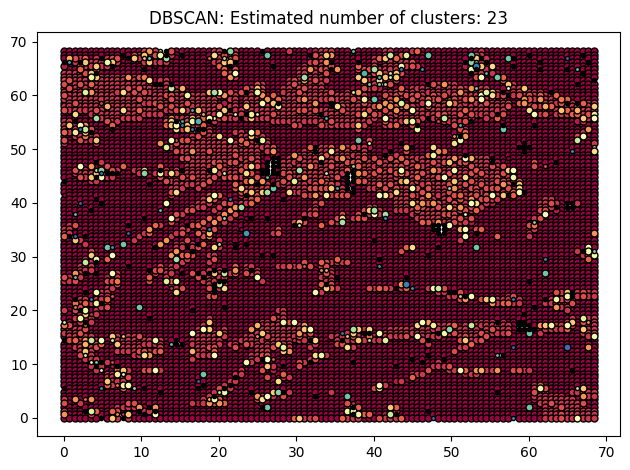

In [16]:
plot_dbscan(db, df_small.to_numpy())

This worked quite well. The clustering algorithm has found the Martensite and ferrite phases by itself, as well as the artefacts (marked in black).

However, we have 23 clusters - let's see if we can improve on this by first normalising the input data-frame.

In [10]:
scaler = StandardScaler()
df_small_norm = scaler.fit_transform(df_small)

In [11]:
db = DBSCAN(eps=0.01, min_samples=10, metric=hardness_metric)
db.fit(df_small_norm)

DBSCAN(eps=0.01, metric=<function hardness_metric at 0x7fb1dc37c5e0>,
       min_samples=10)

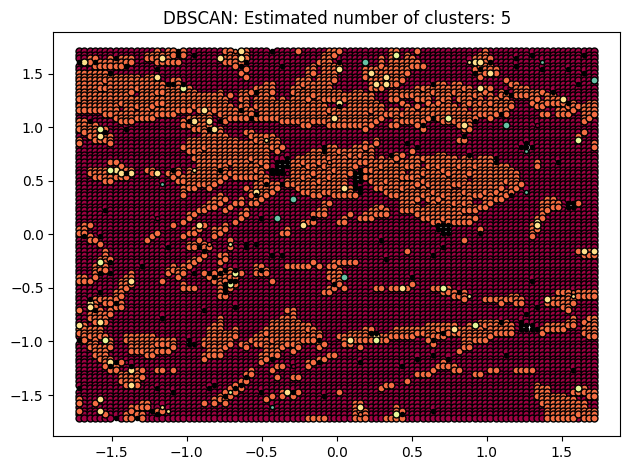

In [12]:
plot_dbscan(db, df_small_norm)

This is much better - we have fewer clusters and most of each phase is in one cluster.
The artefacts are shown in black which, in this visualisation, is marked as "noise". However, they are identified correctly.

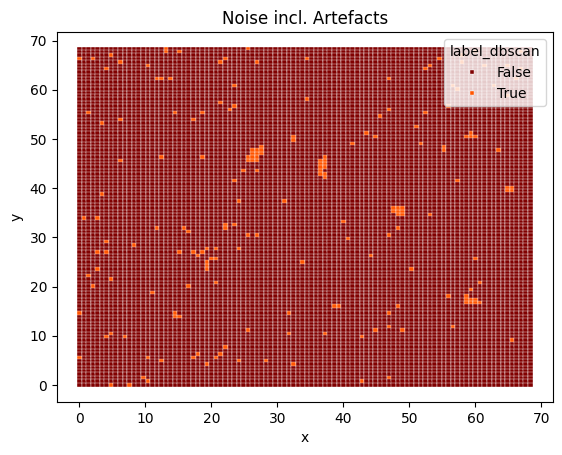

In [13]:
# add the output of the clustering algorithm to the dataframe
labels = db.labels_
df['label_dbscan'] = labels

# plot noise (incl. artefacts)
ax = sns.scatterplot(x=df['x'], y=df['y'], hue=df['label_dbscan']==-1,
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type)

plt.title('Noise incl. Artefacts')
plt.show()

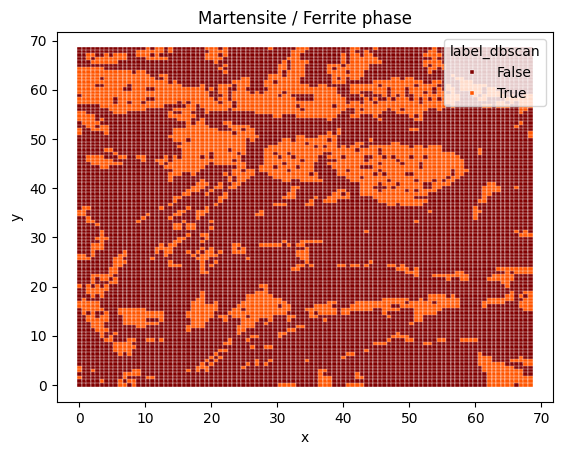

In [14]:
# plot the phases
ax = sns.scatterplot(x=df['x'], y=df['y'], hue=df['label_dbscan']==1,
                  palette=colour_scheme,
                  s=marker_size, marker=marker_type)

plt.title('Martensite / Ferrite phase')
plt.show()

In the next step, we want to find the individual Martensite islands in the sample (as well as the artefacts).
To this end, we use the clustering algorithm again, but now apply it to the clusters we have found in the previous steps.

First, the artefacts:

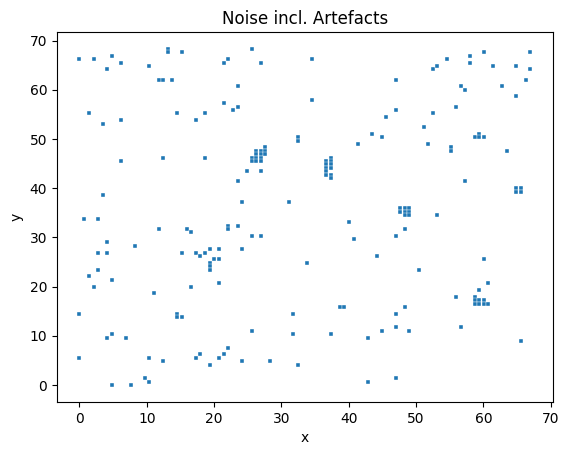

In [15]:
df_artefact = df[df['label_dbscan']==-1].copy()
df_artefact = df_artefact[['x','y']]

ax = sns.scatterplot(x=df_artefact['x'], y=df_artefact['y'],
                  s=marker_size, marker=marker_type)

plt.title('Noise incl. Artefacts')
plt.show()

In [16]:
db_artefact= DBSCAN(eps=1.5, min_samples=5)
db_artefact.fit(df_artefact)


DBSCAN(eps=1.5)

This will find all clusters for the artefacts

In [17]:
labels_artefacts = db_artefact.labels_
df_artefact['label_artefact'] = labels_artefacts

In [18]:
##
## merge information about hardness
##
df = df.join(df_artefact.drop(columns=['x','y']), on='index')

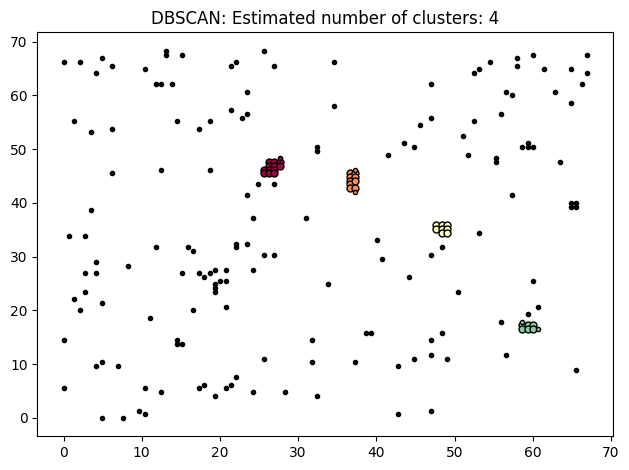

In [19]:
plot_dbscan(db_artefact, df_artefact.to_numpy())

In [20]:
for i in set(labels_artefacts):
    if i>-1:
        mean = np.mean(df[df['label_artefact']==i]['hardness'])
        std  = np.std(df[df['label_artefact']==i]['hardness'])
        print('artefact cluster: ', i)
        print('Mean hardness {:.2f} \u00B1 {:.2f} GPa'.format(mean, std))
        print('-----------------')

artefact cluster:  0
Mean hardness 1.60 ± 0.47 GPa
-----------------
artefact cluster:  1
Mean hardness 1.99 ± 0.33 GPa
-----------------
artefact cluster:  2
Mean hardness 1.19 ± 0.44 GPa
-----------------
artefact cluster:  3
Mean hardness 1.95 ± 0.33 GPa
-----------------


Now we do the same thing for the clusters in the Martensite phase

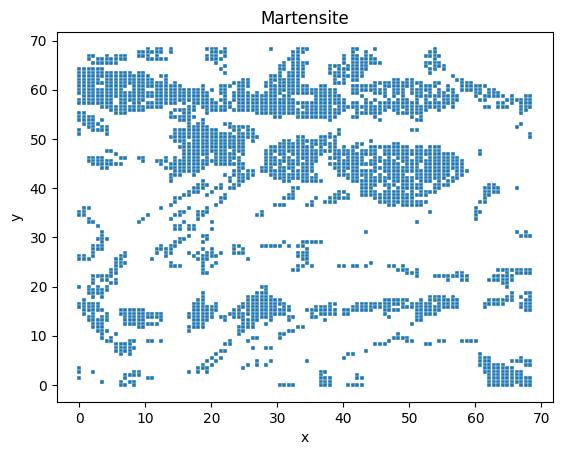

In [21]:
df_martensite = df[df['label_dbscan']==1].copy()
df_martensite = df_martensite[['x','y']]

ax = sns.scatterplot(x=df_martensite['x'], y=df_martensite['y'],
                  s=marker_size, marker=marker_type)

plt.title('Martensite')
plt.show()

In [22]:
db_martensite = DBSCAN(eps=1.5, min_samples=5)
db_martensite.fit(df_martensite)

labels_martensite = db_martensite.labels_


In [23]:
##
## merge information about hardness
##
df_martensite['label_martensite'] = labels_martensite
df = df.join(df_martensite.drop(columns=['x','y']), on='index')

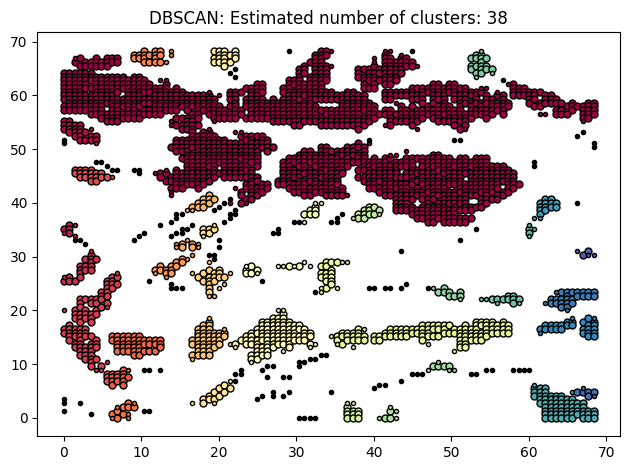

In [24]:
plot_dbscan(db_martensite, df_martensite.to_numpy())

In [25]:
data = []
for i in set(labels_martensite):
    if i>-1:
        mean = np.mean(df[df['label_martensite']==i]['hardness'])
        std  = np.std(df[df['label_martensite']==i]['hardness'])
        data.append([i,mean, std])

In [26]:
df_martensite_hardness = pd.DataFrame(data, columns=['cluster','mean', 'std'])
df_martensite_hardness

cluster      mean       std
0         0  6.613344  0.583677
1         1  7.139957  0.649221
2         2  6.847230  0.664639
3         3  6.831127  0.663004
4         4  6.754991  0.665317
5         5  7.254465  0.530189
6         6  7.143410  0.604198
7         7  6.890000  0.639221
8         8  7.007588  0.721427
9         9  6.927718  0.799733
10       10  6.640829  0.564125
11       11  6.665684  0.742445
12       12  6.518431  0.769317
13       13  6.889571  0.523903
14       14  6.571647  0.651912
15       15  6.559863  0.889056
16       16  6.908097  0.745813
17       17  7.099943  0.708017
18       18  6.818742  0.580820
19       19  6.593863  0.625805
20       20  6.412463  0.837062
21       21  6.504372  0.638793
22       22  6.380368  0.597121
23       23  6.824434  0.599242
24       24  7.036380  0.768108
25       25  6.666141  0.889886
26       26  6.923856  0.694569
27       27  6.378589  0.593894
28       28  6.711307  0.907080
29       29  7.228262  0.676918
30       30  7.163716  0.684553
31       31  6.815076  0.682449
32       32  6.548690  0.472447
33       33  6.849322  0.656547
34       34  7.133541  0.544937
35       35  6.810304  0.766516
36       36  6.818283  0.476162
37       37  7.323110  0.435943

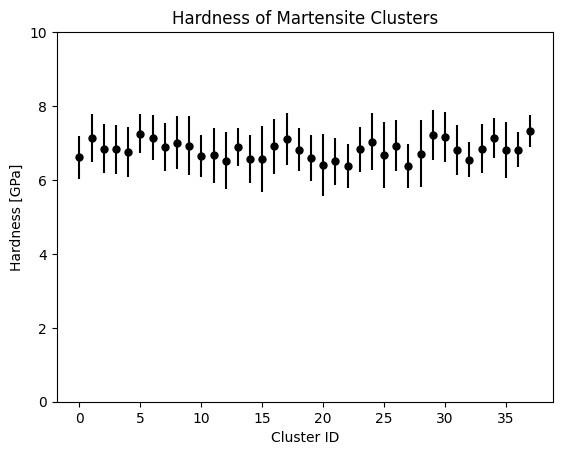

In [27]:
df_martensite_hardness.plot(
    x='cluster',
    y='mean',
    yerr = 'std',
    linestyle='none',
    capsize=0,
    color='black',
    legend=None,
    marker='o',
    markersize=5
)
plt.xlabel('Cluster ID') 
plt.ylabel('Hardness [GPa]') 
plt.ylim(0,10)
plt.title('Hardness of Martensite Clusters')
plt.show()